In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Image/ADNI1/* .

In [ ]:
!cp -r /content/drive/MyDrive/Main_Data/Split/* .

In [ ]:
!tar -xzf adni1_brain_resid.tar.gz

In [ ]:
!tar -xzf adni1_brain_stand.tar.gz

## Load the images

In [ ]:
import glob

images = sorted(glob.glob('processed/**/*.nii.gz', recursive=True))

In [ ]:
import nibabel as nib

In [ ]:
import numpy as np

def check_files(files):
  corrupted = []

  for file_path in files:

    try:
      # Load the NIfTI file
      nifti_img = nib.load(file_path)

      # Get the image data and header
      img_data = nifti_img.get_fdata()

      img_header = nifti_img.header

    except Exception as e:
      corrupted.append(e)

  return corrupted


In [ ]:
# corrupted = check_files(images)

In [ ]:
# corrupted

# CNN - pretrain

## Model

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


class Auto3dCNN11(nn.Module):
    def __init__(self, input_size=(182, 182, 218)): #input: (182, 182, 218)
        super(Auto3dCNN11, self).__init__()

        output_size = list(input_size)
        self.sizes = [[18, 18, 22], [37, 37, 44]]

        self.encoder = nn.Sequential()
        self.decoder = nn.Sequential()

        # Encoder

        self.encoder.append(nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())
        self.encoder.append(nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)))
        self.encoder.append(nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.encoder.append(nn.ReLU())

        # Decoder

        self.decoder.append(nn.ConvTranspose3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[0], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)))
        self.decoder.append(nn.ReLU())
        self.decoder.append(nn.Upsample(size=self.sizes[1], mode='trilinear', align_corners=False))
        self.decoder.append(nn.ConvTranspose3d(32, 1, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2), output_padding=(1, 1, 2)))
        self.decoder.append(nn.Tanh())

    def forward(self, x):

        outputs = []
        for i, layer in enumerate(self.encoder):
          if i % 3 == 0: # convolution
            x = layer(x)
          elif i % 3 == 1: # activation
            x = layer(x)
            outputs.append(x)
          else: # upsample
            x = layer(x)

        out_i = len(outputs) - 1
        for i, layer in enumerate(self.decoder):
          if i % 3 == 0: # convolution
            x = x + outputs[out_i]
            x = layer(x)
            out_i -= 1
          elif i % 3 == 1: # activation
            x = layer(x)
          else: # upsample
            x = layer(x)
        return x


class ConvBlock11(nn.Module):

  def __init__(self):
    super(ConvBlock11, self).__init__()

    self.conv1 = nn.Conv3d(1, 32, kernel_size=(5, 5, 5), stride=(5, 5, 5), padding=(2, 2, 2))
    self.batch_norm1 = nn.BatchNorm3d(32)
    self.pool1 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv2 = nn.Conv3d(32, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm2 = nn.BatchNorm3d(16)
    self.pool2 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

    self.conv3 = nn.Conv3d(16, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    self.batch_norm3 = nn.BatchNorm3d(8)
    self.pool3 = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

  def forward(self, x):

    x = self.pool1(F.relu(self.batch_norm1(self.conv1(x))))
    x = self.pool2(F.relu(self.batch_norm2(self.conv2(x))))
    x = self.pool3(F.relu(self.batch_norm3(self.conv3(x))))

    return x


class FullNetwork11(nn.Module):

  def __init__(self, encoder, num_classes=3):
    super(FullNetwork11, self).__init__()

    self.encoder = encoder

    for param in list(self.encoder.parameters()):
        param.requires_grad = False

    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(8 * 4 * 4 * 5, 12)
    self.batch_norm_fc = nn.BatchNorm1d(12)
    self.fc2 = nn.Linear(12, num_classes)

  def forward(self, x):

    x = self.encoder(x)

    x = self.flatten(x)
    x = F.relu(self.batch_norm_fc(self.fc1(x)))
    x = self.fc2(x)

    return x


In [ ]:
from torchsummary import summary

In [ ]:
summary(Auto3dCNN11(), (1, 182, 182, 218), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 37, 37, 44]           4,032
              ReLU-2       [-1, 32, 37, 37, 44]               0
         MaxPool3d-3       [-1, 32, 18, 18, 22]               0
            Conv3d-4       [-1, 16, 18, 18, 22]          13,840
              ReLU-5       [-1, 16, 18, 18, 22]               0
         MaxPool3d-6         [-1, 16, 9, 9, 11]               0
            Conv3d-7          [-1, 8, 9, 9, 11]           3,464
              ReLU-8          [-1, 8, 9, 9, 11]               0
   ConvTranspose3d-9         [-1, 16, 9, 9, 11]           3,472
             ReLU-10         [-1, 16, 9, 9, 11]               0
         Upsample-11       [-1, 16, 18, 18, 22]               0
  ConvTranspose3d-12       [-1, 32, 18, 18, 22]          13,856
             ReLU-13       [-1, 32, 18, 18, 22]               0
         Upsample-14       [-1, 32, 37,

In [ ]:
model = None
del model

## dataset creation

In [ ]:
import pandas as pd

tp = 'm36' # sc, m06, m12, m18, m24, m36

tuning_df = pd.read_csv('ADNI1_tune.csv').drop('Unnamed: 0', axis=1).query(f'Visit == "{tp}"')
testing_df = pd.read_csv('ADNI1_test.csv').drop('Unnamed: 0', axis=1).query(f'Visit == "{tp}"')

In [ ]:
## if two classes:
# tuning_df = tuning_df[tuning_df['Group'] != 'MCI']
# testing_df = testing_df[testing_df['Group'] != 'MCI']

In [ ]:
from sklearn.model_selection import train_test_split

Subjects, Groups = tuning_df[['Subject', 'Group']].drop_duplicates(['Subject']).T.to_numpy()
train_subjects, valid_subjects = train_test_split(Subjects, test_size=0.11, random_state=22, stratify=Groups)

train_df = tuning_df[tuning_df['Subject'].isin(train_subjects)][['Image Data ID','Group','Subject']]
train_images, train_labels, train_subjects = train_df.T.to_numpy()

valid_df = tuning_df[tuning_df['Subject'].isin(valid_subjects)][['Image Data ID','Group','Subject']]
valid_images, valid_labels, valid_subjects = valid_df.T.to_numpy()


In [ ]:
import re

def make_id_translator(paths):
  return {re.search('((I|D)\d{3,8})\.', x).group(1): x for x in paths}

id_to_path = make_id_translator(images)

In [ ]:
def image_exists(sample):
  image_id, group = sample
  return image_id in id_to_path

train_set = list(zip(train_images, train_labels))

train_set = list(filter(image_exists, train_set))

train_images, train_labels = zip(*train_set)

In [ ]:
train_image_paths = [id_to_path[k] for k in train_images]

In [ ]:
valid_set = list(zip(valid_images, valid_labels))

valid_set = list(filter(image_exists, valid_set))

valid_images, valid_labels = zip(*valid_set)

In [ ]:
valid_image_paths = [id_to_path[k] for k in valid_images]

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import nibabel as nib
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
from torch.utils.data import WeightedRandomSampler, RandomSampler


class CNNDatasetShifted(Dataset):

    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform
        self.scale = scale

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.labels[idx]

        # Load NIfTI image
        nifti_img = nib.load(file_path)

        # Get the image data
        img_data = nifti_img.get_fdata()

        # Min Max Scale normalization
        max_i = img_data.max()
        min_i = img_data.min()
        img_data = (img_data - min_i) / (max_i - min_i)

        # subsample by the factor of 4
        x_shift = random.randint(-1,1)
        y_shift = random.randint(-1,1)
        z_shift = random.randint(-1,1)
        img_data = np.roll(img_data, (x_shift, y_shift, z_shift), (0, 1, 2))

        # Expand dimensions to add a channel (assuming grayscale images)
        img_data = np.expand_dims(img_data, axis=0)

        # Permute dimensions to match [batch_size, channels, depth, height, width]
        # (42, 42, 50) -> (50, 42, 42)
        img_data = torch.FloatTensor(img_data).permute(0, 3, 1, 2)

        if self.transform:
            img_data = self.transform(img_data)

        return img_data, torch.FloatTensor(label)


# Convert labels to one-hot encoding
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_labels)
y_valid_encoded = le.transform(valid_labels)
n_classes = len(le.classes_)

# Compute weights
total = len(y_train_encoded) + len(y_valid_encoded)
weights = [total/(np.count_nonzero(y_train_encoded == i) + np.count_nonzero(y_valid_encoded == i)) for i in range(len(le.classes_))]
scale = 4

# weighted
weight_encoded = [weights[i] for i in y_train_encoded]
sampler = WeightedRandomSampler(weight_encoded, num_samples=scale*len(y_train_encoded), replacement=True)

y_train_one_hot = torch.nn.functional.one_hot(torch.tensor(y_train_encoded), num_classes=n_classes).float()
y_valid_one_hot = torch.nn.functional.one_hot(torch.tensor(y_valid_encoded), num_classes=n_classes).float()

# Create custom datasets
train_dataset = CNNDatasetShifted(file_paths=train_image_paths, labels=y_train_one_hot)
valid_dataset = CNNDatasetShifted(file_paths=valid_image_paths, labels=y_valid_one_hot)

batch_size = 32
num_workers = 8
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=sampler,  num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)



In [ ]:
n_classes

2

In [ ]:
len(train_loader)

44

In [ ]:
len(valid_loader)

2

## loading the pretrained convolutional layer

In [ ]:
!cp /content/drive/MyDrive/Main_Data/Checkpoints/part2/3c_combined_fullnetwork11_adni1.pth .

In [ ]:
conv_block = ConvBlock11()
model = FullNetwork11(encoder=conv_block, num_classes=3)

In [ ]:
if not torch.cuda.is_available():
  checkpoint = torch.load('3c_combined_fullnetwork11_adni1.pth', map_location=torch.device('cpu'))
else:
  checkpoint = torch.load('3c_combined_fullnetwork11_adni1.pth')

model.load_state_dict(checkpoint['model_state_dict'], strict=False)

<All keys matched successfully>

In [ ]:
import os, shutil, re

def prepare_model(basename="combined_fullnetwork11_adni1.pth", num_classes=2):

  filename = f"{num_classes}c_" + basename

  if not os.path.isfile(filename):
    shutil.copy(f'/content/drive/MyDrive/Main_Data/Checkpoints/part2/{filename}', filename)

  conv_block = ConvBlock11()

  if num_classes == 2 or num_classes == 3:
    model = FullNetwork11(encoder=conv_block, num_classes=num_classes)
  else:
    raise Exception('you should only use 2 or 3 classes for your model.')

  if not torch.cuda.is_available():
    checkpoint = torch.load(filename, map_location=torch.device('cpu'))
  else:
    checkpoint = torch.load(filename)

  model.load_state_dict(checkpoint['model_state_dict'], strict=False)

  for param in model.parameters():
    param.requires_grad = False

  for name, param in model.named_parameters():
    if 'fc' in name or '3' in name:
        param.requires_grad = True

  return model

## training

In [ ]:
import shutil
import os
from torch.utils.tensorboard import SummaryWriter

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, train_losses, test_losses, scheduler=None, early_stopper=None):

    save_path = '/content/drive/MyDrive/Main_Data/Checkpoints/part2/timepoints' # outsource the timepoint

    if not os.path.isdir(save_path):
      os.makedirs(save_path)

    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'test_losses': test_losses
    }

    if scheduler is not None:
        checkpoint['scheduler'] = scheduler.state_dict()

    if early_stopper is not None:
        checkpoint['early_stopper'] = early_stopper.state_dict()

    torch.save(checkpoint, filename)
    shutil.copyfile(filename, os.path.join(save_path, filename))

def load_checkpoint(filename, model, optimizer, scheduler=None, early_stopper=None):

    if not torch.cuda.is_available():
      checkpoint = torch.load(filename, map_location=torch.device('cpu'))
    else:
      checkpoint = torch.load(filename)

    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_losses = checkpoint['train_losses']
    test_losses = checkpoint['test_losses']

    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler'])

    if early_stopper is not None:
        early_stopper.load_state_dict(checkpoint['early_stopper'])

    return epoch, train_losses, test_losses


In [ ]:
from typing import Dict, Any
from typing_extensions import TypeAlias
StateDict: TypeAlias = Dict[str, Any]

class StateDictAttributeError(AttributeError):

  def __init__(self, attribute_name):
    super().__init__(f"your state_dict lacks the parameter \"{attribute_name}\".")


class EarlyStopper:

    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

    def state_dict(self):
      return {"patience": self.patience, "min_delta": self.min_delta, "counter": self.counter, "min_validation_loss": self.min_validation_loss}

    def load_state_dict(self, state_dict: StateDict):

      if "patience" in state_dict:
        self.patience = state_dict["patience"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"patience\".")

      if "min_delta" in state_dict:
        self.min_delta = state_dict["min_delta"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_delta\".")

      if "counter" in state_dict:
        self.counter = state_dict["counter"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"counter\".")

      if "min_validation_loss" in state_dict:
        self.min_validation_loss = state_dict["min_validation_loss"]
      else:
        raise AttributeError("your state_dict lacks the parameter \"min_validation_loss\".")


In [ ]:
def get_confusion_matrix(y_true, y_pred, classes):
  cf_matrix = confusion_matrix(y_true, y_pred)
  df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                      columns = [i for i in classes])
  return df_cm

In [ ]:
params_filename = f'3c_timepoint-{tp}_fullnetwork11_adni1.pth'

In [ ]:
import torch
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.metrics import confusion_matrix, f1_score

classes = le.classes_
n_classes = len(classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Instantiate the model
model = prepare_model(num_classes=3)
model.to(device)

# Number of training epochs
num_epochs = 10

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5) #lr=0.001
scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.75, total_iters=num_epochs)
early_stopper = EarlyStopper(patience=5, min_delta=0.01)

s_epoch = -1

# Initialize the loss arrays
train_losses = []
valid_losses = []

# Load the training data if needed
if os.path.isfile(params_filename):
  s_epoch, train_losses, valid_losses = load_checkpoint(params_filename, model, optimizer, scheduler, early_stopper)

# Training loop
for epoch in range(s_epoch + 1, num_epochs):

    # Training step
    model.train()

    y_true_train = []
    y_pred_train = []
    epoch_train_loss = 0

    print(f'Epoch {epoch}:')
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Calculate the loss
        loss = criterion(output, target)
        epoch_train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update weights
        optimizer.step()

        y_true_train.extend(torch.argmax(target, dim=1).cpu().numpy())
        y_pred_train.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Training metrics
    epoch_train_loss = epoch_train_loss / len(train_loader)
    print(f'Training Loss: {epoch_train_loss:.4f}')

    train_accuracy = np.sum(np.array(y_true_train) == np.array(y_pred_train)) / len(y_true_train)
    print(f'Training Accuracy: {train_accuracy * 100:.2f}%')

    train_f1 = f1_score(y_true_train, y_pred_train, average='weighted')
    print(f'Training F1-Score: {train_f1 * 100:.2f}%')

    df_cm_train = get_confusion_matrix(y_true_train, y_pred_train, classes)
    print(df_cm_train)


    # Validation step
    model.eval()

    epoch_valid_loss = 0
    y_true_valid = []
    y_pred_valid = []

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(valid_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            epoch_valid_loss += loss.item()
            y_true_valid.extend(torch.argmax(target, dim=1).cpu().numpy())
            y_pred_valid.extend(torch.argmax(output, dim=1).cpu().numpy())


    # Validation metrics
    epoch_valid_loss = epoch_valid_loss / len(valid_loader) # not accurate, needs weighting (in loop multiply by minibatch size, outside divide by length of dataset)
    print(f'Validation Loss: {epoch_valid_loss:.4f}')

    valid_accuracy = np.sum(np.array(y_true_valid) == np.array(y_pred_valid)) / len(y_true_valid)
    print(f'Validation Accuracy: {valid_accuracy * 100:.2f}%')

    valid_f1 = f1_score(y_true_valid, y_pred_valid, average='weighted')
    print(f'Validation F1-Score: {valid_f1 * 100:.2f}%')

    df_cm_valid = get_confusion_matrix(y_true_valid, y_pred_valid, classes)
    print(df_cm_valid)


    # Summing up the epoch
    train_losses.append(epoch_train_loss)
    valid_losses.append(epoch_valid_loss)

    before_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    after_lr = optimizer.param_groups[0]["lr"]
    print("Epoch %d: SGD lr %.6f -> %.6f" % (epoch, before_lr, after_lr))

    print(f'Epoch {epoch}: saving...')
    save_checkpoint(params_filename, epoch, model, optimizer, train_losses, valid_losses, scheduler=scheduler, early_stopper=early_stopper)

    # Check for early stopping possiblity
    if early_stopper.early_stop(epoch_valid_loss):
      print('Exitting this epoch early...')
      break




Epoch 0:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9862
Training Accuracy: 51.73%
Training F1-Score: 50.64%
           AD        CN      MCI
AD   0.552743  0.236287  0.21097
CN   0.093023  0.706977  0.20000
MCI  0.260331  0.425620  0.31405


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.1128
Validation Accuracy: 39.53%
Validation F1-Score: 38.21%
           AD        CN       MCI
AD   0.333333  0.222222  0.444444
CN   0.066667  0.600000  0.333333
MCI  0.157895  0.578947  0.263158
Epoch 0: SGD lr 0.000020 -> 0.000019
Epoch 0: saving...
Epoch 1:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9632
Training Accuracy: 53.17%
Training F1-Score: 51.89%
           AD        CN       MCI
AD   0.600000  0.200000  0.200000
CN   0.065315  0.711712  0.222973
MCI  0.283925  0.417537  0.298539


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0594
Validation Accuracy: 46.51%
Validation F1-Score: 45.53%
           AD        CN       MCI
AD   0.555556  0.111111  0.333333
CN   0.133333  0.600000  0.266667
MCI  0.157895  0.526316  0.315789
Epoch 1: SGD lr 0.000019 -> 0.000019
Epoch 1: saving...
Epoch 2:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9659
Training Accuracy: 53.31%
Training F1-Score: 52.33%
           AD        CN       MCI
AD   0.584946  0.191398  0.223656
CN   0.116935  0.685484  0.197581
MCI  0.285714  0.414520  0.299766


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0208
Validation Accuracy: 41.86%
Validation F1-Score: 38.63%
           AD        CN       MCI
AD   0.666667  0.111111  0.222222
CN   0.066667  0.600000  0.333333
MCI  0.421053  0.421053  0.157895
Epoch 2: SGD lr 0.000019 -> 0.000018
Epoch 2: saving...
Epoch 3:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9671
Training Accuracy: 52.45%
Training F1-Score: 51.08%
           AD        CN       MCI
AD   0.573009  0.212389  0.214602
CN   0.078261  0.715217  0.206522
MCI  0.289916  0.415966  0.294118


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0218
Validation Accuracy: 60.47%
Validation F1-Score: 60.29%
           AD        CN       MCI
AD   0.777778  0.111111  0.111111
CN   0.066667  0.600000  0.333333
MCI  0.105263  0.368421  0.526316
Epoch 3: SGD lr 0.000018 -> 0.000018
Epoch 3: saving...
Epoch 4:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9627
Training Accuracy: 54.03%
Training F1-Score: 53.42%
           AD        CN       MCI
AD   0.559006  0.221532  0.219462
CN   0.094340  0.693920  0.211740
MCI  0.245327  0.406542  0.348131


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0419
Validation Accuracy: 48.84%
Validation F1-Score: 45.43%
           AD        CN       MCI
AD   0.777778  0.000000  0.222222
CN   0.133333  0.666667  0.200000
MCI  0.157895  0.631579  0.210526
Epoch 4: SGD lr 0.000018 -> 0.000018
Epoch 4: saving...
Epoch 5:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9564
Training Accuracy: 54.47%
Training F1-Score: 53.62%
           AD        CN       MCI
AD   0.561224  0.210204  0.228571
CN   0.090526  0.722105  0.187368
MCI  0.255319  0.418440  0.326241


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0364
Validation Accuracy: 46.51%
Validation F1-Score: 44.71%
           AD        CN       MCI
AD   0.666667  0.222222  0.111111
CN   0.200000  0.600000  0.200000
MCI  0.157895  0.578947  0.263158
Epoch 5: SGD lr 0.000018 -> 0.000017
Epoch 5: saving...
Epoch 6:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9410
Training Accuracy: 56.99%
Training F1-Score: 55.52%
           AD        CN       MCI
AD   0.610753  0.191398  0.197849
CN   0.071274  0.775378  0.153348
MCI  0.271739  0.406522  0.321739


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0892
Validation Accuracy: 44.19%
Validation F1-Score: 41.25%
           AD        CN       MCI
AD   0.777778  0.111111  0.111111
CN   0.200000  0.533333  0.266667
MCI  0.263158  0.526316  0.210526
Epoch 6: SGD lr 0.000017 -> 0.000017
Epoch 6: saving...
Epoch 7:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9564
Training Accuracy: 55.19%
Training F1-Score: 53.93%
           AD        CN       MCI
AD   0.617204  0.202151  0.180645
CN   0.084416  0.722944  0.192641
MCI  0.266811  0.418655  0.314534


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0790
Validation Accuracy: 41.86%
Validation F1-Score: 38.54%
           AD        CN       MCI
AD   0.666667  0.111111  0.222222
CN   0.066667  0.600000  0.333333
MCI  0.263158  0.578947  0.157895
Epoch 7: SGD lr 0.000017 -> 0.000016
Epoch 7: saving...
Epoch 8:


  0%|          | 0/44 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Training Loss: 0.9588
Training Accuracy: 52.81%
Training F1-Score: 51.45%
           AD        CN       MCI
AD   0.572016  0.224280  0.203704
CN   0.075515  0.734554  0.189931
MCI  0.266667  0.445161  0.288172


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Validation Loss: 1.0355
Validation Accuracy: 53.49%
Validation F1-Score: 51.54%
           AD        CN       MCI
AD   0.777778  0.111111  0.111111
CN   0.133333  0.666667  0.200000
MCI  0.263158  0.421053  0.315789
Epoch 8: SGD lr 0.000016 -> 0.000016
Epoch 8: saving...
Exitting this epoch early...


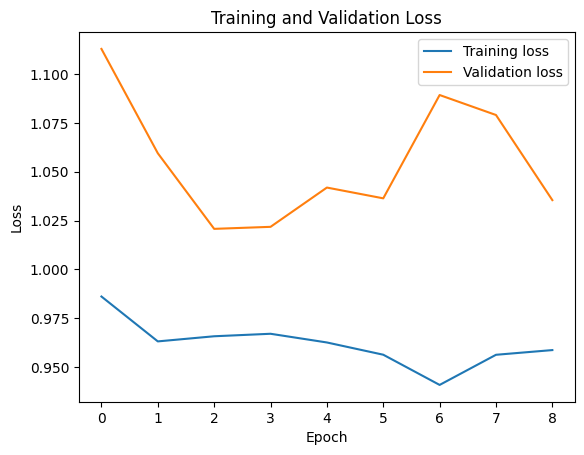

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()